In [1]:
import sys 
import os

sys.path.append(os.path.abspath(".."))

In [2]:
device = "cuda"

In [3]:
nb_inputs = 96

In [4]:
nb_outputs = 2

In [5]:
dataloader_cfg = {
    "data_dir": "/home/cc/efficient-rsnn-bmi/data/datasets",
    "ratio_val": 0.1,
    "random_val": False,
    "extend_data": True,
    "sample_duration": 2.0,
    "remove_segments_inactive": False,
    "p_drop": 0.0,
    "p_insert": 0.0,
    "jitter_sigma": 0.0,
    "dtype": "float32",
    "dt": 4e-3,
}

In [6]:
from omegaconf import OmegaConf
import torch
from efficient_rsnn_bmi.core.dataloader import get_dataloader

dataloader_cfg = OmegaConf.create(dataloader_cfg)
dtype = getattr(torch, dataloader_cfg.dtype)
dataloader = get_dataloader(dataloader_cfg, dtype=dtype)

In [7]:
baseline_model = "/home/cc/efficient-rsnn-bmi/pretrained_models/baselines/baseline.pth"
interpolation_model = "/home/cc/efficient-rsnn-bmi/pretrained_models/interpolations/2_keys_interpolation.pth"

In [8]:
filename = "indy_20170131_02.mat"

In [9]:
train_dat, val_data, test_dat = dataloader.get_single_session_data(filename)

Loading indy_20170131_02.mat
[2025-06-22 11:14:00] [INFO] [efficient_rsnn_bmi.base.dataloader] - Extending data...


In [10]:
training_config = {
    "training": {
        "batch_size": 250,
        "SG_beta": 20,
        "LB_L2_strength": 100,
        "LB_L2_thresh": 1e-3,
        "UB_L2_strength": 0.01,
        "UB_L2_thresh": 10,
    }
}

training_config = OmegaConf.create(training_config)

In [11]:
nb_time_steps = int(dataloader_cfg.sample_duration / dataloader_cfg.dt)

nb_time_steps

500

In [12]:
# from efficient_rsnn_bmi.experiments.models.rsnn.rsnn import BaselineRecurrentSpikingModel

# model = BaselineRecurrentSpikingModel(
#     batch_size = training_config.training.batch_size,
#     nb_time_steps = nb_time_steps,
#     nb_inputs = nb_inputs,
#     device = device,
#     dtype = dtype,
# )

In [13]:
from efficient_rsnn_bmi.experiments.models.rsnn.rsnn_interpolate import InterpolateRecurrentSpikingModel

model = InterpolateRecurrentSpikingModel(
    batch_size = training_config.training.batch_size,
    nb_time_steps = nb_time_steps,
    nb_inputs = nb_inputs,
    device = device,
    dtype = dtype,
    n_keys= 2,
)

In [14]:
model_config = {
    "model": {
        "stochastic": False,
        "dropout_p": 0.3,
        "nb_hidden": 1,
        "hidden_size": [64],
        "recurrent": [True],
        "multiple_readout": False,
        "tau_mem_readout": 50e-3,
        "tau_syn_readout": 10e-3,
        "tau_mem": 20e-3,
        "tau_syn": 10e-3,
        "het_timescales": True,
        "het_timescales_readout": True,
        "learn_timescales": True,
        "learn_timescales_readout": True,
        "delta_synapse": False,
        "is_half": True
    }
}

model_config = OmegaConf.create(model_config)

In [15]:
import stork

activation_function = stork.activations.CustomSpike
if model_config.model.stochastic:
    activation_function.escape_noise_type = "sigmoid"
else:
    activation_function.escape_noise_type = "step"

activation_function.escape_noise_params = {"beta": training_config.training.SG_beta}
activation_function.surrogate_type = "SuperSpike"
activation_function.surrogate_params = {"beta": training_config.training.SG_beta}

regs = []
regLB = stork.regularizers.LowerBoundL2(
    strength = training_config.training.LB_L2_strength,
    threshold = training_config.training.LB_L2_thresh,
    dims = False,
)
regUB = stork.regularizers.UpperBoundL2(
    strength = training_config.training.UB_L2_strength,
    threshold = training_config.training.UB_L2_thresh,
    dims = 1,
)
regs.append(regLB)
regs.append(regUB)

In [16]:
def compute_input_firing_rates(data, cfg):
    mean1 = 0
    mean2 = 0

    for i in range(len(data)):
        mean1 += torch.sum(data[i][0][:, :96]) / cfg.sample_duration / 96
        try:
            mean2 += torch.sum(data[i][0][:, 96:]) / cfg.sample_duration / 96
        except:
            continue

    mean1 /= len(data)
    mean2 /= len(data)

    # For LOCO
    print (data[0][0].shape)
    if data[0][0].shape[1] == 192:
        return mean1, mean2

    # FOR INDY
    else:
        return mean1, None

In [17]:
mean1, mean2 = compute_input_firing_rates(train_dat, dataloader_cfg)

torch.Size([500, 96])


In [18]:
initializers_config = {
    "initializer": {
        "compute_nu": True,
        "sigma_u": 0.5,
        "nu": 20,
        "alpha": 0.9
    }
}
initializers_config = OmegaConf.create(initializers_config)

In [19]:
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer
)

hidden_init = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=initializers_config.initializer.sigma_u,
    nu=mean1,
    timestep=dataloader_cfg.dt,
    alpha=initializers_config.initializer.alpha,
    dtype=dtype,
)

readout_init = DistInitializer(
    dist=torch.distributions.Normal(0, 1),
    scaling="1/sqrt(k)",
    dtype=dtype,
)

In [20]:
from stork.nodes import InputGroup
from stork.layers import Layer
from stork.connections import Connection
from efficient_rsnn_bmi.base.lif import CustomLIFGroup
from efficient_rsnn_bmi.base.readout import CustomReadoutGroup

input_group = model.add_group(
    InputGroup(
       shape=nb_inputs,
        dropout_p=model_config.model.dropout_p,
    )
)

for i in range (model_config.model.nb_hidden):
    hidden_layer = Layer(
        name = f"hidden_{i}",
        model = model,
        size = model_config.model.hidden_size[i],
        input_group = input_group,
        recurrent = model_config.model.recurrent[i],
        regs = regs,
        neuron_class = CustomLIFGroup,
        neuron_kwargs={
            "tau_mem": model_config.model.tau_mem,
            "tau_syn": model_config.model.tau_syn,
            "activation": activation_function,
            "dropout_p": model_config.model.dropout_p,
            "het_timescales": model_config.model.het_timescales,
            "learn_timescales": model_config.model.learn_timescales,
            "is_delta_syn": model_config.model.delta_synapse,
        },
    )

    current_src_grp = hidden_layer.output_group
    print(current_src_grp)

    hidden_init.initialize(hidden_layer)

    if i == 0 and nb_inputs == 192 and train_dat is not None:
        with torch.no_grad():
            hidden_layer.connections[0].weight[:, :96] /= mean2 / mean1
        
    # Add single RO group
    readout_group = model.add_group(
        CustomReadoutGroup(
            nb_outputs,
            tau_mem = model_config.model.tau_mem_readout,
            tau_syn = model_config.model.tau_syn_readout,
            het_timescales = model_config.model.het_timescales_readout,
            learn_timescales = model_config.model.learn_timescales_readout,
            initial_state = -1e-2,
            is_delta_syn = model_config.model.delta_synapse,
        )
    )

    print("Readout group shape: ", readout_group.shape)
    print("Current source group shape: ", current_src_grp.shape)
    print(current_src_grp, readout_group)
    con_ro = model.add_connection(
        Connection(current_src_grp, readout_group, dtype=dtype)
    )

    readout_init.initialize(con_ro)

CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
)
Readout group shape:  (2,)
Current source group shape:  (64,)
CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
) CustomReadoutGroup()


In [21]:
from efficient_rsnn_bmi.base.loss import RootMeanSquareError
from stork.optimizers import SMORMS3
import numpy as np
import random
from stork.generators import StandardGenerator

loss_class = RootMeanSquareError()

opt_kwargs = {
    "lr": 2e-3
}

opt_kwargs["eps"] = 1e-5 if dtype == torch.float16 else 1e-16

opt = SMORMS3
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": 200} # nb of epoch train

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

generator = StandardGenerator(
    nb_workers=2,
    worker_init_fn=worker_init_fn,
)

model.configure(
    input=model.groups[0],
    output=model.groups[-1],
    loss_stack=loss_class,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=opt_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dataloader_cfg.dt,
)

In [22]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
Connection(
  (src): InputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=96, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=64, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomReadoutGroup()
  (op): Linear(in_features=64, out_features=2, bias=False)
)


In [23]:
loaded_model_state = torch.load(interpolation_model)

In [24]:
model.load_state_dict(loaded_model_state)

<All keys matched successfully>

In [25]:
model = model.half()

In [26]:
test_dat.dtype = torch.float16
eval_loss_class = RootMeanSquareError()

model.set_nb_steps(test_dat[0][0].shape[0])
model.loss_stack = eval_loss_class

In [27]:
with torch.no_grad():
    model.train(False)
    model.prepare_data(test_dat)

    for local_X, local_y in model.data_generator(test_dat, shuffle=False):
        output = model.forward_pass(local_X, cur_batch_size=len(local_X))

t=10, lower_bounds=2


In [29]:
import json

with open("baseline_step_logs_1.json", "r") as f:
    step_logs = json.load(f)


In [38]:
step_logs['baseline']

[{'t': 0,
  'group': 'Input',
  'input': [[0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0]]},
 {'t': 0,
  'group': 'hidden_0',
  'input': [[0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0

In [45]:
hidden_logs = [entry for entry in step_logs['baseline'] if entry['group'].startswith('hidden_0')]

In [49]:
len(hidden_logs[0]['input'][0])

64

In [50]:
hidden_0_channel_0 = [entry['input'][0][0] for entry in hidden_logs]

In [63]:
hidden_0_channel_0

[0.0,
 0.373046875,
 0.27392578125,
 -0.13232421875,
 0.26025390625,
 -0.4287109375,
 -0.11822509765625,
 0.0,
 1.09765625,
 0.08843994140625,
 0.11480712890625]

In [52]:
len(hidden_0_channel_0)

11

In [53]:
with open('interpolated_step_logs.json', 'r') as f:
    interpolated_step_logs = json.load(f)

In [55]:
hidden_logs_interpolated = [entry for entry in interpolated_step_logs['interpolated'] if entry['group'].startswith('hidden_0')]

In [62]:
hidden_logs_interpolated[0]['interpolation'][0][0][0]

-0.2509765625

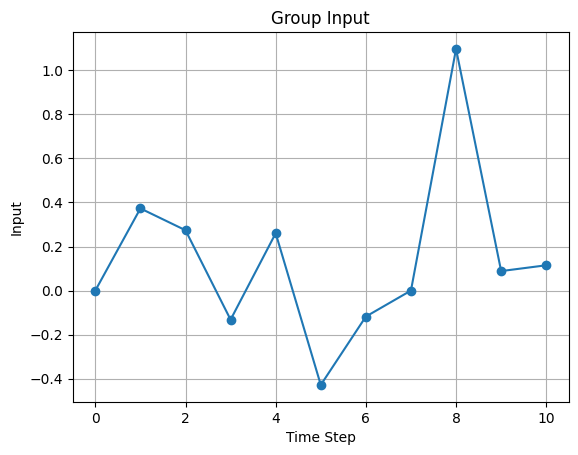

In [66]:
import matplotlib.pyplot as plt

data = [
    0.0,
    0.373046875,
    0.27392578125,
    -0.13232421875,
    0.26025390625,
    -0.4287109375,
    -0.11822509765625,
    0.0,
    1.09765625,
    0.08843994140625,
    0.11480712890625
]

plt.plot(data, marker='o')  # optional: marker='o' to show points
plt.title("Group Input")
plt.xlabel("Time Step")
plt.ylabel("Input")
plt.grid(True)
plt.show()